In [429]:
import yaml
import sys
import os
import math

import pandas as pd
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt

PATH = "../pypsa-eur/"
RUN = "20231025-zecm"

sys.path.append(os.path.join(PATH, "scripts/"))
from plot_summary import rename_techs

from snakemake.utils import update_config

plt.style.use(["bmh", "../pypsa-eur/matplotlibrc"])
xr.set_options(display_style="html")

In [430]:
# for EU: https://ec.europa.eu/eurostat/databrowser/view/prc_hicp_aind__custom_9900786/default/table?lang=en
EUR_2015_TO_2020 = (1.002*1.017*1.019*1.015*1.007)
EUR_2015_TO_2020

1.0613493817548298

In [431]:
CLUSTERS = 110
BASE_OPTS = "Co2L0-2190SEG-T-H-B-I-S-A"
OUTPUT = f"./{RUN}/"

if not os.path.exists(OUTPUT):
    os.makedirs(OUTPUT)

SCENARIOS = PATH + "results/" + RUN + "/csvs/"

In [432]:
with open(f"../../config/config.yaml") as base:
    config = yaml.safe_load(base)
    with open(f"../../config/config.{RUN}.yaml") as file:
        update_config(config, yaml.safe_load(file))

In [433]:
def rename_techs_tyndp(tech):
    tech = rename_techs(tech)
    if "heat pump" in tech or "resistive heater" in tech:
        return "power-to-heat"
    # elif tech in ["H2 Electrolysis", "methanation", "H2 liquefaction"]:
    #     return "power-to-gas"
    elif "H2 pipeline" in tech or "gas pipeline" in tech:
        return "pipeline"
    elif tech in ["H2", "H2 Store"]:
        return "H2 storage"
    # elif tech in ["OCGT", "CHP", "gas boiler", "gas", "H2 Fuel Cell"]:
    elif tech in ["OCGT", "CHP"]:
        return "gas-to-power/heat"
    elif "solar" in tech and not "external" in tech:
        return "solar"
    elif tech in ["Fischer-Tropsch", "methanolisation"]:
        return "power-to-liquid"
    elif "offshore wind" in tech:
        return "offshore wind"
    elif "CC" in tech or "sequestration" in tech:
        return "carbon capture and storage"
    elif tech == "biomass boiler":
        return "solid biomass"
    else:
        return tech

In [434]:
NICE_NAMES = {
    "external onwind": "onshore wind (outside Europe)",
    "external solar": "solar (outside Europe)",
    "import hvdc-to-elec": "HVDC import links",
    "import pipeline-h2": "hydrogen imports (pipeline)",
    "import shipping-lh2": "hydrogen imports (ship)",
    "import shipping-ftfuel": "Fischer-Tropsch imports",
    "import shipping-meoh": "methanol imports",
    "import shipping-lch4": "methane imports (ship)",
    "import shipping-lnh3": "ammonia imports",
    "import shipping-steel": "steel imports",
    "DRI + Electric arc": "DRI + electric arc furnace",
    "DAC": "direct air capture",
}

In [435]:
preferred_order = pd.Index(
    [
        "transmission lines",
        "electricity distribution grid",
        "fossil oil and gas",
        "hydroelectricity",
        "hydro reservoir",
        "run of river",
        "pumped hydro storage",
        "solid biomass",
        "biogas",
        "onshore wind",
        "offshore wind",
        "offshore wind (AC)",
        "offshore wind (DC)",
        "solar PV",
        "solar thermal",
        "solar rooftop",
        "solar",
        "building retrofitting" "ground heat pump",
        "air heat pump",
        "heat pump",
        "resistive heater",
        "power-to-heat",
        "H2 Fuel Cell",
        "gas-to-power/heat",
        "CHP",
        "OCGT",
        "gas boiler",
        "gas",
        "natural gas",
        "gas pipeline",
        "H2 pipeline",
        "pipeline",
        "CO2 sequestration",
        "CCS",
        "power-to-gas",
        "power-to-H2",
        "H2 Electrolysis",
        "H2 liquefaction",
        "H2 storage",
        "hydrogen storage",
        "methanation",
        "power-to-liquid",
        "battery storage",
        "hot water storage",
        "oil",
        "methanol",
    ]
)

In [436]:
def make_new_index(df):

    cols = df.columns.get_level_values("opt").str.split("-").str[-1].str.split("+", n=1)

    level1 = [
        "none" if not c0.startswith("imp") else ("any" if pd.isna(c1) else c1)
        for c0, c1 in zip(cols.str[0], cols.str[1])
    ]

    def parse_limit(c):
        try:
            return float(c)
        except:
            if c:
                return 0.0
            else:
                return np.inf

    level0 = cols.str[0].str[3:].map(parse_limit)

    df.columns = pd.MultiIndex.from_tuples(
        zip(level0, level1), names=["limit", "carrier"]
    )

In [437]:
supply_energy = pd.read_csv(
    SCENARIOS + "supply_energy.csv", header=[0, 1, 2, 3], index_col=[0, 1, 2]
).fillna(0.0)

In [438]:
# temporary: remove final six scenarios
# energy = energy.loc[:,~energy.columns.get_level_values('opt').str.contains("NH3-FT")]
supply_energy = supply_energy.iloc[:, :-7]

In [439]:
make_new_index(supply_energy)

In [440]:
co2_carriers = ["co2", "co2 stored", "process emissions"]
carrier = [i for i in supply_energy.index.levels[0] if i not in co2_carriers]

In [441]:
supply_energy = supply_energy.loc[carrier].groupby(level=2).sum().div(1e6)

In [442]:
# 2.1 kWh / kg of steel (or MWh/t)
supply_energy.loc[supply_energy.index.str.contains("steel")] *= 2.1

In [443]:
supply_energy.index = [
    i[:-1]
    if ((i not in ["co2", "NH3", "H2"]) and (i[-1:] in ["0", "1", "2", "3"]))
    else i
    for i in supply_energy.index
]

In [444]:
supply_energy = supply_energy.groupby(supply_energy.index).sum()
supply_energy = (
    supply_energy.groupby(supply_energy.index.map(rename_techs_tyndp))
    .sum()
    .sort_index()
)

In [445]:
to_drop = supply_energy.index[supply_energy.abs().max(axis=1).fillna(0.0) < 1]
supply_energy.drop(to_drop, inplace=True)

In [446]:
imp_vol = (
    supply_energy.filter(regex="(import|external)", axis=0)
    .sum()
    .xs(np.inf, level="limit")
    .round()
)
imp_vol = imp_vol[~imp_vol.index.duplicated(keep="first")]

In [447]:
supply_energy.columns = pd.MultiIndex.from_tuples(
    [(0.0, c) if c == "none" else (l, c) for l, c in supply_energy.columns],
    names=["limit", "carrier"],
)

In [448]:
costs = pd.read_csv(SCENARIOS + "costs.csv", header=[0, 1, 2, 3], index_col=[0, 1, 2])
# inflation adjustment
costs *= EUR_2015_TO_2020

In [449]:
# temporary: remove faulty scenario definition
# costs = costs.loc[:,~costs.columns.get_level_values('opt').str.contains("NH3-FT")]
costs = costs.iloc[:, :-7]

In [450]:
make_new_index(costs)

In [451]:
# remove fixed costs of existing infrastructure that only show up in a subset of scenarios
costs.drop(("links", "capital", "import shipping-lch4"), inplace=True, errors="ignore")


In [452]:
tech_colors = config["plotting"]["tech_colors"]
tech_colors["pipeline"] = tech_colors["gas pipeline"]
tech_colors["gas"] = "#baac9e"
tech_colors["gas-to-power/heat"] = tech_colors["CHP"]

In [473]:
carrier = "any"
# carrier = "AC+H21.2+CH41.2+NH31.2+FT1.2+MeOH1.2+St1.2"
# carrier = "AC+H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1+St1.1"
# carrier = "AC+H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9+St0.9"
# carrier = "AC+H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8+St0.8"
# carrier = "AC+H20.7+CH40.7+NH30.7+FT0.7+MeOH0.7+St0.7"

df = costs.groupby(level=2).sum().div(1e9)
df = df.groupby(df.index.map(rename_techs_tyndp)).sum()
df.columns = pd.MultiIndex.from_tuples(
    [(imp_vol[c], c) if math.isinf(l) else (l, c) for l, c in df.columns],
    names=["limit", "carrier"],
)
to_drop = df.index[df.max(axis=1).fillna(0.0) < 1]
df.drop(to_drop, inplace=True)
order = preferred_order.intersection(df.index).append(
    df.index.difference(preferred_order)
)
df = df.loc[order]


def get_subset(df, carrier):
    sel = df.columns.get_level_values("carrier").isin(["none", carrier])

    dfr = df.loc[:, sel]

    dfr.columns = dfr.columns.get_level_values("limit")

    return dfr

In [474]:
## playground
x = get_subset(df, "any").sort_index(axis=1).sum()
-x + x[0]

limit
0.0          0.000000
500.0       17.344891
1000.0      28.164081
1500.0      34.072877
2000.0      37.664168
2800.0      40.005035
3000.0      39.944322
4000.0      34.772046
5000.0      19.583413
6000.0      -8.032874
7000.0     -47.402388
8000.0     -96.004980
9000.0    -152.079938
10000.0   -217.497686
dtype: float64

/tmp/ipykernel_101231/765142725.py:14: UserWarning: This pattern is interpreted as a regular expression, and has match groups. To actually get the groups, use str.extract.
  internal_tsc = dfr.loc[~dfr.index.str.contains("(import|external)")].sum().sort_index()


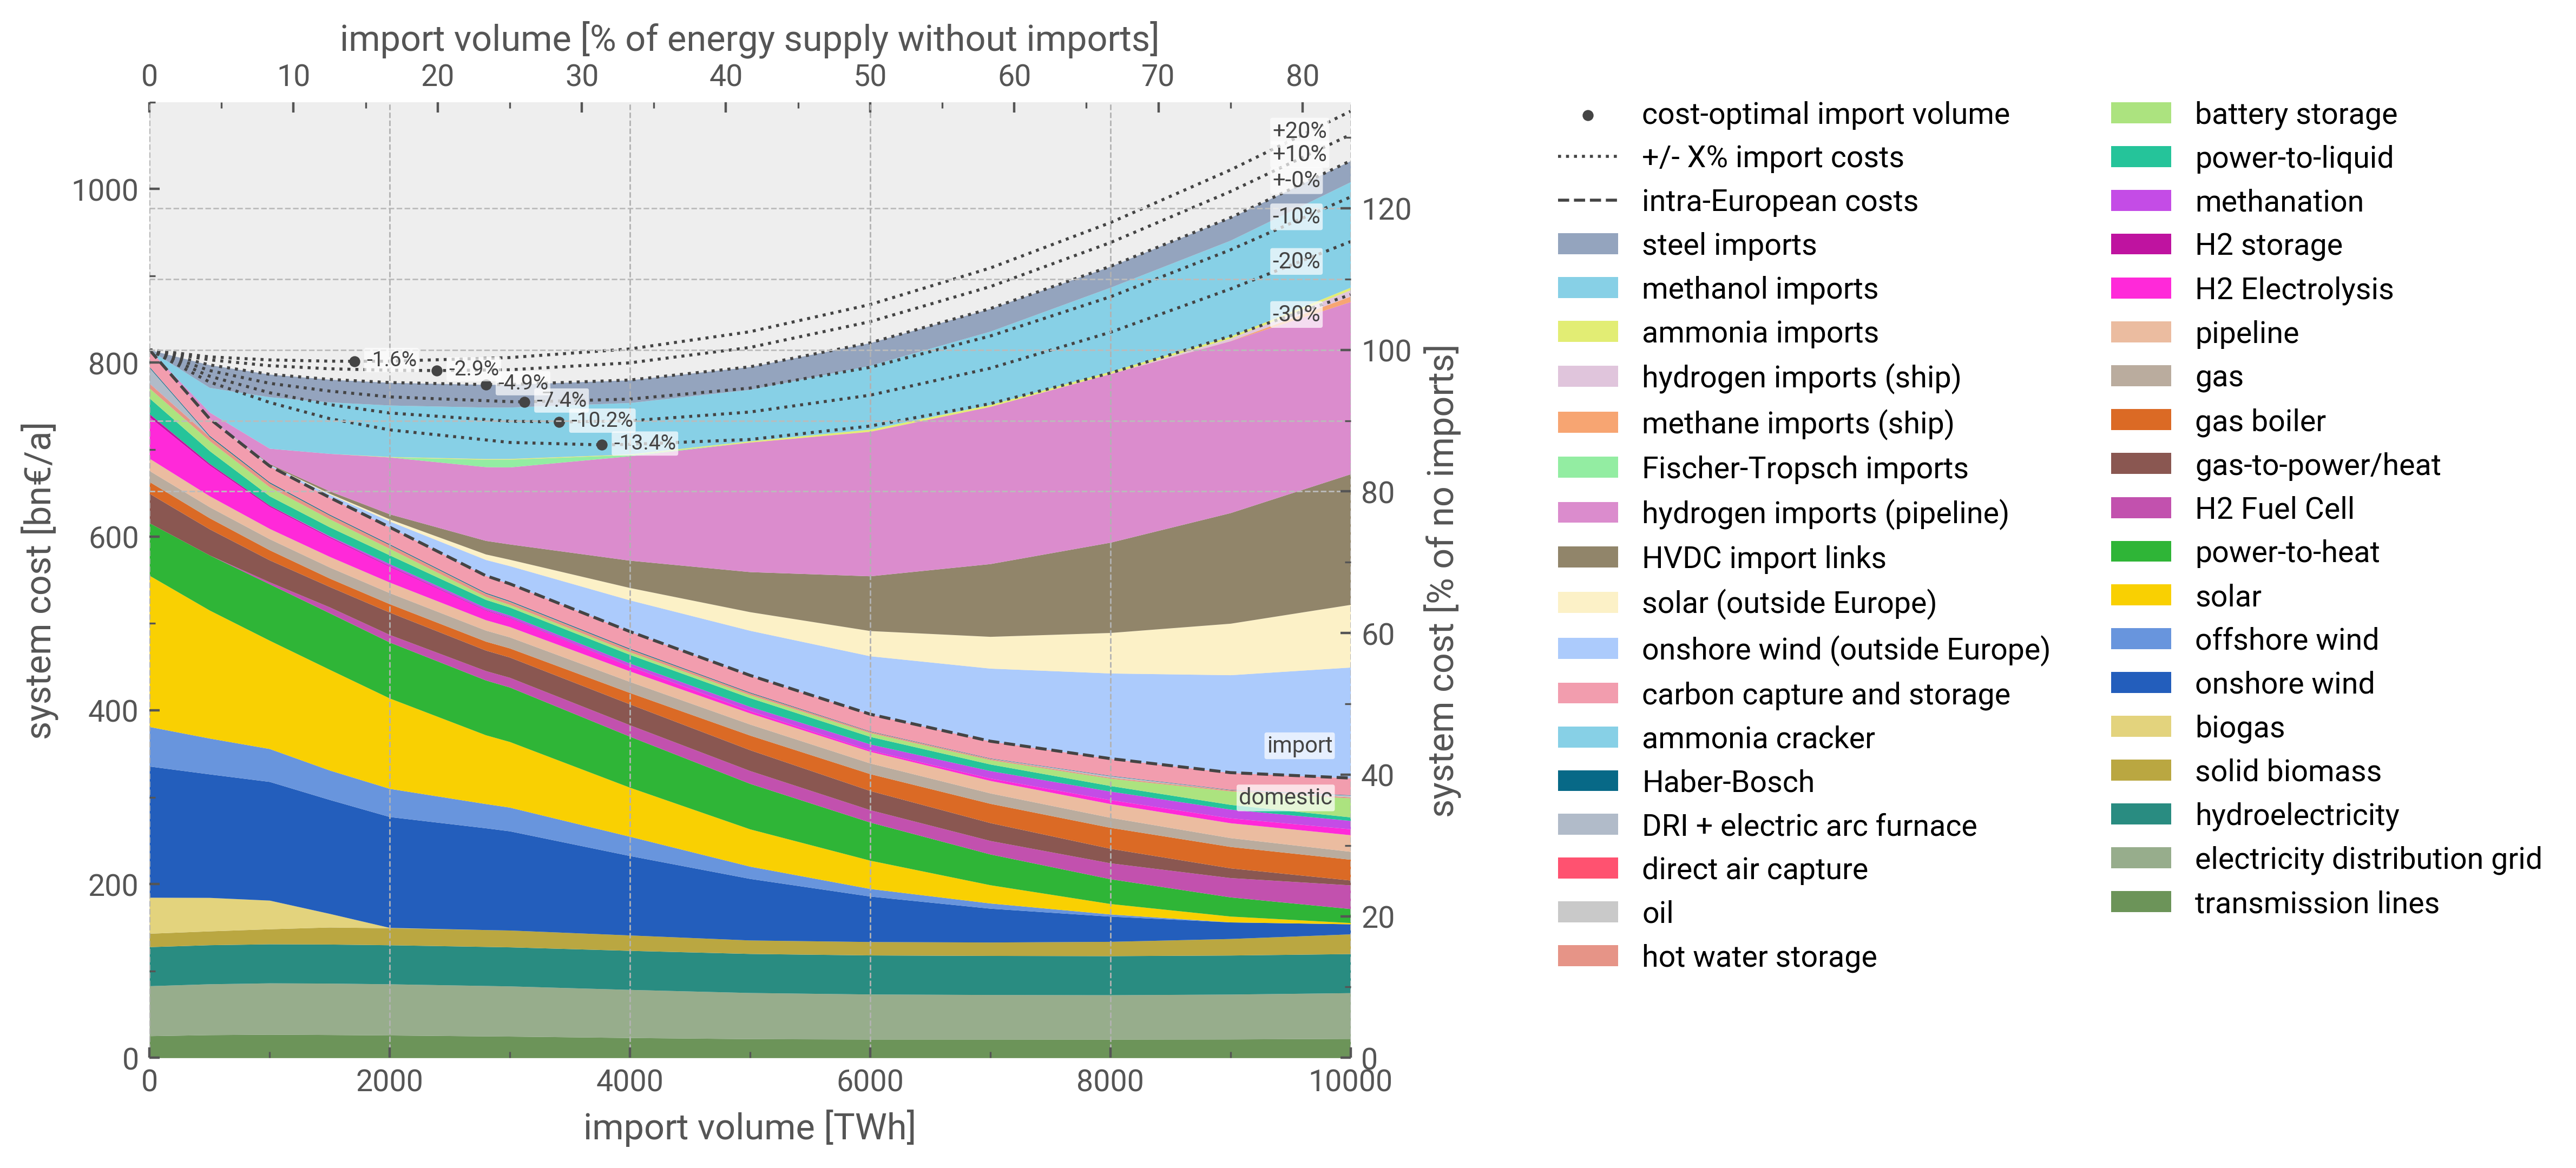

In [475]:
dfr = get_subset(df, carrier)
supplemental_carriers = {
    "-30%": "AC+H20.7+CH40.7+NH30.7+FT0.7+MeOH0.7+St0.7",
    "-20%": "AC+H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8+St0.8",
    "-10%": "AC+H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9+St0.9",
    "+-0%": "any",
    "+10%": "AC+H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1+St1.1",
    "+20%": "AC+H21.2+CH41.2+NH31.2+FT1.2+MeOH1.2+St1.2",
}
supplemental_sensitivity = {
    k: get_subset(df, v).sum().sort_index() for k, v in supplemental_carriers.items()
}

internal_tsc = dfr.loc[~dfr.index.str.contains("(import|external)")].sum().sort_index()
fig, ax = plt.subplots(
    1,
    1,
    figsize=(12, 5.5),
)

to_plot = dfr.T.sort_index()

no_import_costs = dfr[0.0].sum()

colors = [tech_colors[i] for i in df.index]

to_plot.plot.area(ax=ax, stacked=True, linewidth=0, color=colors)

internal_tsc.plot(
    ax=ax, linestyle="--", linewidth=1, color="#444", label="intra-European costs"
)

for i, (label, data) in enumerate(supplemental_sensitivity.items()):
    data.plot(
        ax=ax,
        linestyle=":",
        linewidth=1,
        color="#444",
        alpha=1,
        label="+/- X% import costs" if i == 0 else None,
    )

    minimum_rel = (data - no_import_costs).div(no_import_costs).mul(-100).round(1)
    minimum_abs = (no_import_costs - data).round(1)

    x = minimum_abs.idxmax()
    y = data.min()
    plt.scatter(x, y, color="#444", s=10, label="cost-optimal import volume" if i == 0 else None)

    bbox = dict(
        boxstyle="round,pad=0.1", edgecolor="none", facecolor="white", alpha=0.7
    )

    ax.annotate(
        f"-{minimum_rel[x]}%",
        (x + 100, y - 5),
        color="#444",
        bbox=bbox,
        fontsize=7,
    )

    ax.annotate(
        label,
        (9350, data.max() - 30),
        color="#444",
        bbox=bbox,
        fontsize=7.5,
    )

ax.annotate(
    "domestic",
    (9850, internal_tsc.min() - 30),
    color="#444",
    bbox=bbox,
    fontsize=7.5,
    ha="right",
)

ax.annotate(
    "import",
    (9850, internal_tsc.min() +30),
    color="#444",
    bbox=bbox,
    fontsize=7.5,
    ha="right",
)

handles, labels = ax.get_legend_handles_labels()

labels = [NICE_NAMES.get(i, i) for i in labels]

handles.reverse()
labels.reverse()

ax.set_xlim(0, 10000)
ax.set_xlabel("import volume [TWh]")

ax.set_ylim([0, 1100])
ax.set_ylabel("system cost [bn€/a]")
ax.grid(axis="y")

ax.legend(handles, labels, ncol=2, frameon=False, bbox_to_anchor=(1.15, 1.03))

ax.set_axisbelow(False)
ax.tick_params(rotation=0)


def abs2rel(x):
    return x / 12000 * 100


def rel2abs(x):
    return x * 12000 / 100


secax = ax.secondary_xaxis("top", functions=(abs2rel, rel2abs))
secax.set_xlabel("import volume [% of energy supply without imports]")


def abs2rel(x):
    return x / no_import_costs * 100


def rel2abs(x):
    return x * no_import_costs / 100


secax2 = ax.secondary_yaxis("right", functions=(abs2rel, rel2abs), zorder=10)
secax2.set_ylabel("system cost [% of no imports]")

secax2.set_yticks(
    [0, 20, 40, 60, 80, 100, 120],
)
secax2.set_yticks([10, 30, 50, 70, 90, 110, 130], minor=True)
secax.set_xticks(range(5, 100, 10), minor=True)
ax.set_yticks([100, 300, 500, 700, 900, 1100], minor=True)
ax.set_xticks(range(1000, 10000, 2000), minor=True)

for i in ["top", "right", "left", "bottom"]:
    secax.spines[i].set_visible(False)
    secax2.spines[i].set_visible(False)
    ax.spines[i].set_visible(False)

for y in [80, 90, 100, 110, 120]:
    ax.axhline(rel2abs(y), ls="--", color="#bbb", lw=0.5)

for ext in [".pdf", ".png"]:
    fig.savefig(
        OUTPUT + f"sensitivity-import-volume-{carrier}" + ext, bbox_inches="tight"
    )

In [492]:
suffix = ""

if suffix == "":
    translate = {
        "AC": "only\nelectricity",
        "H2": "only\nhydrogen",
        "CH4": "only\nmethane",
        "NH3": "only\nammonia",
        "FT": "only\nFischer-\nTropsch",
        "MeOH": "only\nmethanol",
        "MeOH+FT": "only\nmethanol\n& Fischer-\nTropsch",
        "St": "only\nsteel",
        "H2+CH4+NH3+FT+MeOH": "all but\nelectricity\nand steel",
        "H2+CH4+NH3+FT+MeOH+St": "all but\nelectricity",
        "CH4+NH3+FT+MeOH+St": "only\nhydrogen\nderivatives\nand steel",
        "CH4+NH3+FT+MeOH": "only\nhydrogen\nderivatives",
        # "CH4+FT+MeOH": "only\nhydrogen\nderivatives\nwith carbon",
        "any": "all imports\nallowed",
        "self-sufficient": "no\nimports",
    }
elif suffix == "-m20pc":
    translate = {
        "AC0.8": "only\nelectricity",
        "H20.8": "only\nhydrogen",
        "CH40.8": "only\nmethane",
        "NH30.8": "only\nammonia",
        "FT0.8": "only\nFischer-\nTropsch",
        "MeOH0.8": "only\nmethanol",
        "MeOH0.8+FT0.8": "only\nmethanol\n& Fischer-\nTropsch",
        "St0.8": "only\nsteel",
        "H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8": "all but\nelectricity\nand steel",
        "H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8+St0.8": "all but\nelectricity",
        "CH40.8+NH30.8+FT0.8+MeOH0.8+St0.8": "only\nhydrogen\nderivatives\nand steel",
        "CH40.8+NH30.8+FT0.8+MeOH0.8": "only\nhydrogen\nderivatives",
        # "CH40.8+FT0.8+MeOH0.8": "only\nhydrogen\nderivatives\nwith carbon",
        "AC+H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8+St0.8": "all imports\nallowed",
        "self-sufficient": "no\nimports",
    }
elif suffix == "-m10pc":
    translate = {
        "AC0.9": "only\nelectricity",
        "H20.9": "only\nhydrogen",
        "CH40.9": "only\nmethane",
        "NH30.9": "only\nammonia",
        "FT0.9": "only\nFischer-\nTropsch",
        "MeOH0.9": "only\nmethanol",
        "MeOH0.9+FT0.9": "only\nmethanol\n& Fischer-\nTropsch",
        "St0.9": "only\nsteel",
        "H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9": "all but\nelectricity\nand steel",
        "H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9+St0.9": "all but\nelectricity",
        "CH40.9+NH30.9+FT0.9+MeOH0.9+St0.9": "only\nhydrogen\nderivatives\nand steel",
        "CH40.9+NH30.9+FT0.9+MeOH0.9": "only\nhydrogen\nderivatives",
        # "CH40.9+FT0.9+MeOH0.9": "only\nhydrogen\nderivatives\nwith carbon",
        "AC+H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9+St0.9": "all imports\nallowed",
        "self-sufficient": "no\nimports",
    }
elif suffix == "-p10pc":
    translate = {
        "AC1.1": "only\nelectricity",
        "H21.1": "only\nhydrogen",
        "CH41.1": "only\nmethane",
        "NH31.1": "only\nammonia",
        "FT1.1": "only\nFischer-\nTropsch",
        "MeOH1.1": "only\nmethanol",
        "MeOH1.1+FT1.1": "only\nmethanol\n& Fischer-\nTropsch",
        "St1.1": "only\nsteel",
        "H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1": "all but\nelectricity\nand steel",
        "H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1+St1.1": "all but\nelectricity",
        "CH41.1+NH31.1+FT1.1+MeOH1.1+St1.1": "only\nhydrogen\nderivatives\nand steel",
        "CH41.1+NH31.1+FT1.1+MeOH1.1": "only\nhydrogen\nderivatives",
        # "CH41.1+FT1.1+MeOH1.1": "only\nhydrogen\nderivatives\nwith carbon",
        "AC+H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1+St1.1": "all imports\nallowed",
        "self-sufficient": "no\nimports",
    }

In [493]:
to_plot = df.loc[:, ~df.columns.get_level_values(0).isin(np.arange(500, 10001, 500))]

to_plot.columns = [
    "self-sufficient" if c[0] == 0.0 and c[1] == "none" else c[1]
    for c in to_plot.columns
]

to_plot = to_plot.groupby(
    lambda x: x if "import" in x or "external" in x else "European system"
).sum()


to_plot = to_plot.loc[:, translate.keys()].rename(columns=translate)

to_plot = to_plot.loc[:, to_plot.sum().sort_values(ascending=False).index]

# make sure no imports is first
first = "no\nimports"
cols = [first] + [col for col in to_plot if col != first]
to_plot = to_plot[cols]

# temporary fix until rerun
# to_plot.loc["import shipping-lch4", "only\nmethane"] -= to_plot["only\nmethane"].sum() - to_plot["no\nimports"].sum()

abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)

In [494]:
to_plot = to_plot.groupby(lambda x: "electricity imports (HVDC)" if x in ["external onwind", "external solar", "import hvdc-to-elec"] else x).sum()

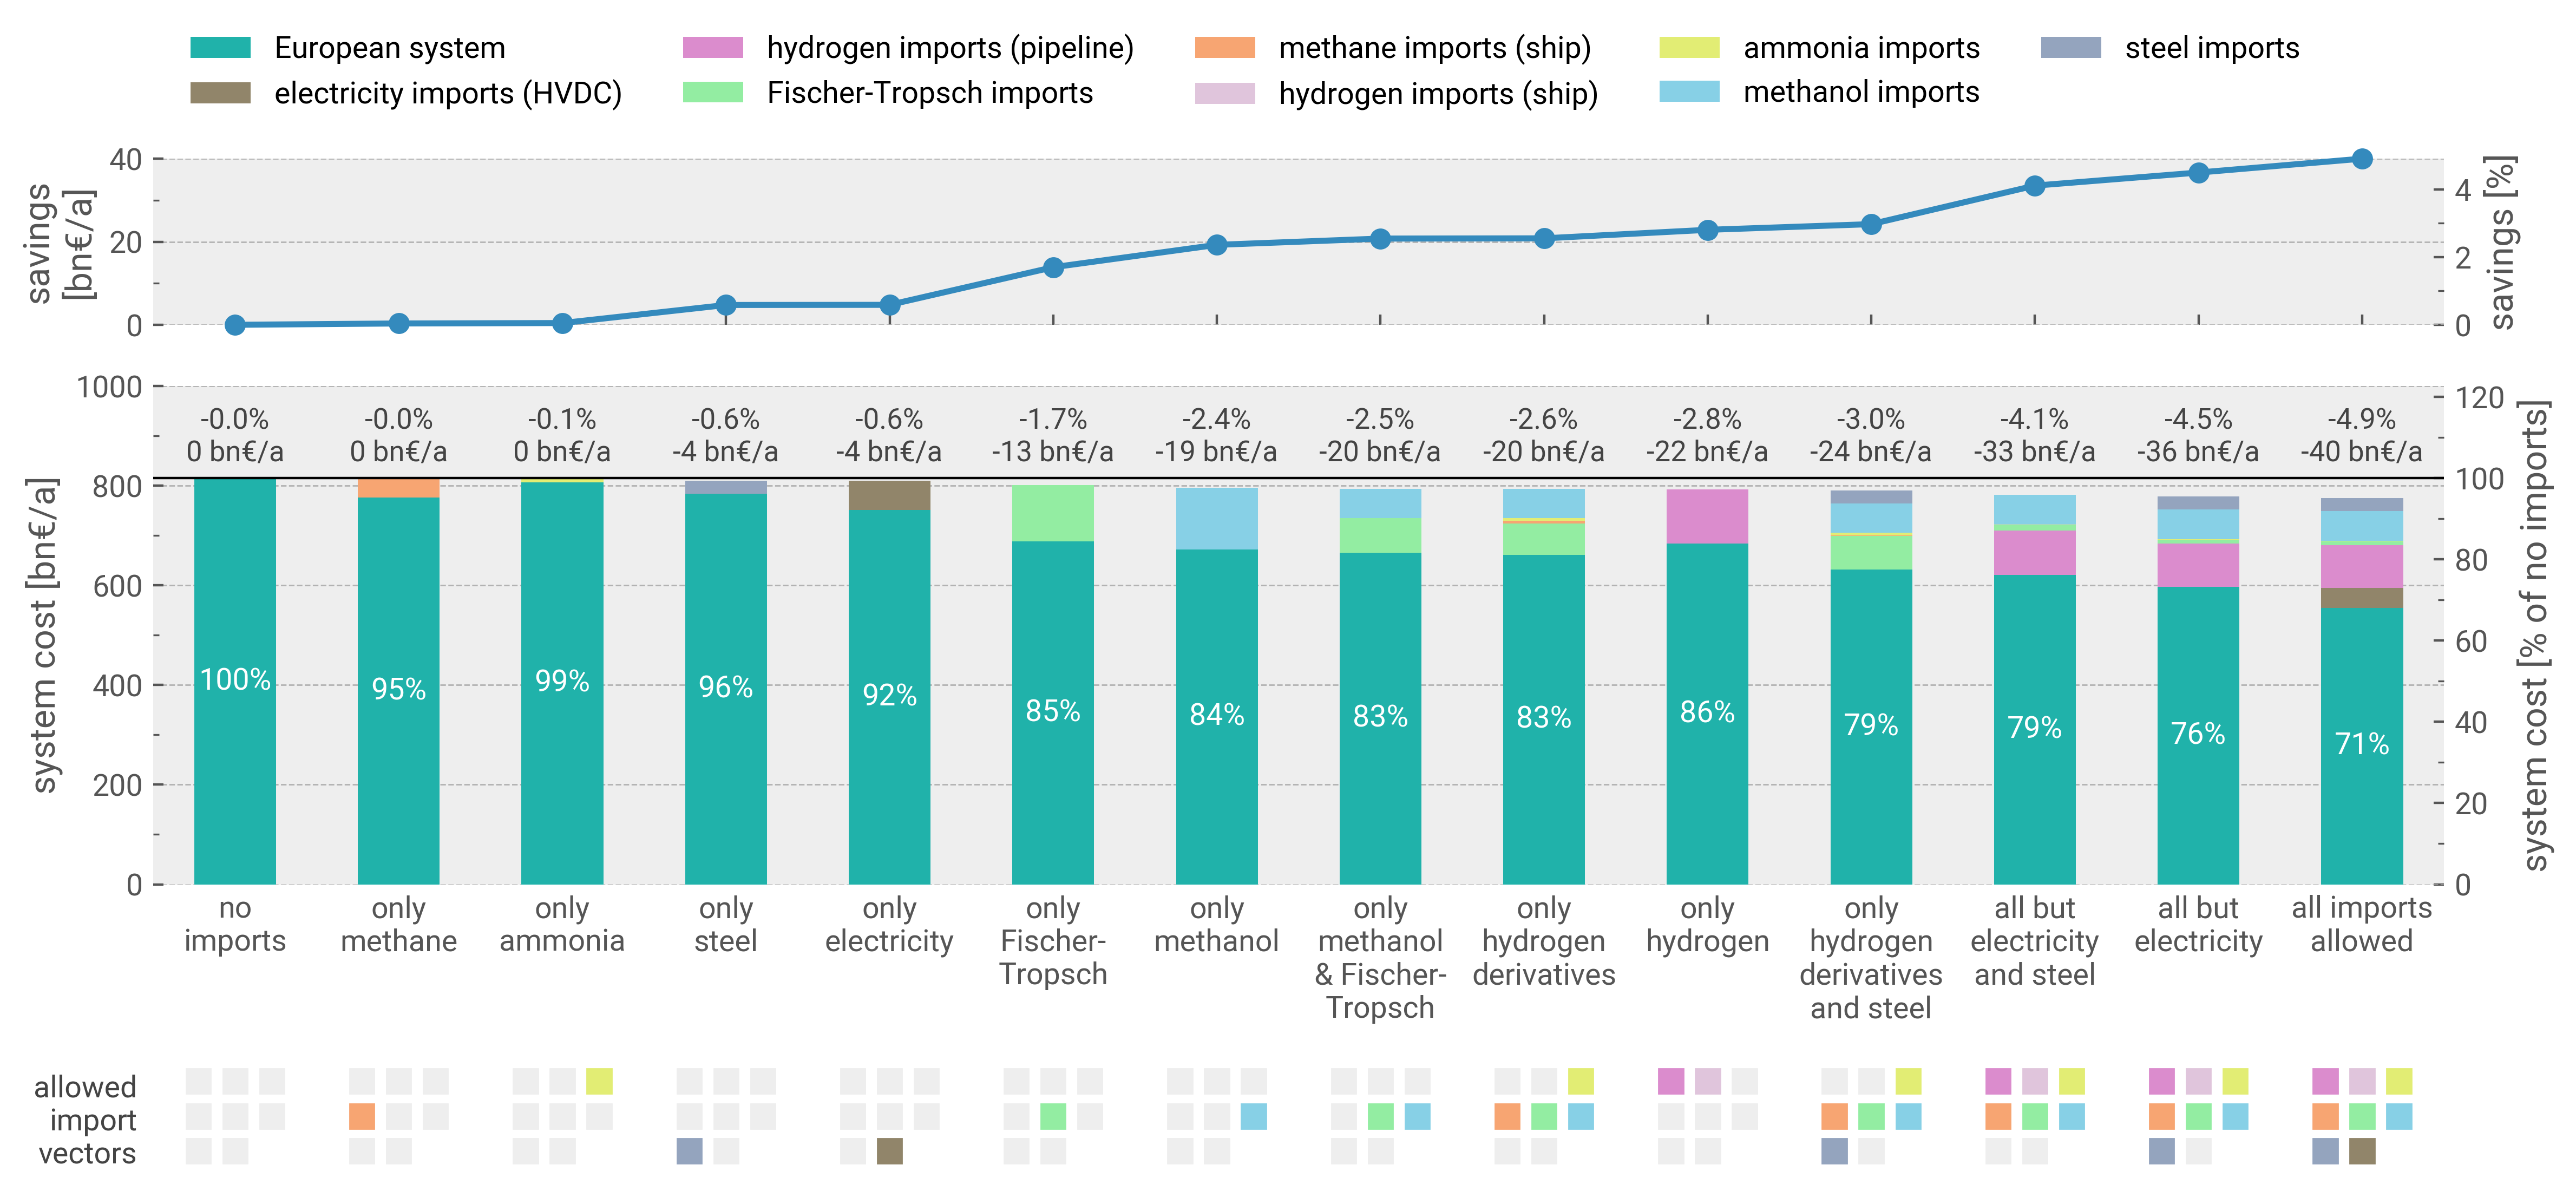

In [495]:
fig, (ax2, ax) = plt.subplots(
    2,
    1,
    figsize=(12, 5),
    gridspec_kw={"height_ratios": [1, 3]},
    sharex=True,
)

tech_colors["European system"] = "lightseagreen"
tech_colors["Import"] = "coral"

reference_cost = to_plot["no\nimports"].sum()

to_plot.T.plot.bar(ax=ax, stacked=True, color=tech_colors, legend=False)

ax.set_ylim([0, 1000])
ax.set_ylabel("system cost [bn€/a]")
ax.grid(axis="x")

ax.axhline(to_plot.sum().max(), linestyle="-", color="k", linewidth=0.8)

share = to_plot / to_plot.sum() * 100
reduction = ((-to_plot.sum() + to_plot.sum().max()) / to_plot.sum().max() * 100).round(
    1
)
abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)

for i, scen in enumerate(to_plot.columns):
    ax.text(
        i,
        850,
        f"-{reduction[scen]}%\n{abs_reduction[scen]} bn€/a",
        ha="center",
        fontsize=9.5,
        color="#444",
        # bbox=dict(
        #     facecolor="white", alpha=0.5, edgecolor="none", boxstyle="round,pad=0.3"
        # ),
    )

ax.bar_label(
    ax.containers[0],
    labels=share.loc["European system"].astype(int).astype(str) + "%",
    label_type="center",
    color="white",
    fmt="%.0f",
)

handles, labels = ax.get_legend_handles_labels()
labels = [NICE_NAMES.get(i, i) for i in labels]
fig.legend(handles, labels, ncol=5, frameon=False, bbox_to_anchor=(0.9, 1.1))


ax.tick_params(rotation=0, labelsize=10)


def abs2rel(x):
    return x / reference_cost * 100


def rel2abs(x):
    return x * reference_cost / 100


secax = ax.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax.set_ylabel("system cost [% of no imports]")

secax2 = ax2.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax2.set_ylabel("savings [%]")

for i in ["top", "right", "left", "bottom"]:
    ax.spines[i].set_visible(False)
    secax.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    secax2.spines[i].set_visible(False)

(to_plot.sum().max() - to_plot.sum()).plot(ax=ax2, marker="o", clip_on=False)
ax2.set_ylabel("savings\n[bn€/a]")
ax.set_yticks(range(100, 1000, 200), minor=True)
secax.set_yticks(range(10, 120, 20), minor=True)
ax2.grid(axis="x")


if suffix == "":
    ax2.set_ylim(0, 40)
    ax2.set_yticks(range(0, 41, 20))
    ax2.set_yticks(range(10, 40, 10), minor=True)
    secax2.set_yticks([0, 2, 4])
    secax2.set_yticks([1, 3], minor=True)

else:
    ax2.set_ylim(0, 80)
    ax2.set_yticks(range(0, 81, 20))
    ax2.set_yticks(range(10, 80, 10), minor=True)
    secax2.set_yticks(range(0, 16, 5))
    secax2.set_yticks([2.5, 7.5, 12.5], minor=True)

import matplotlib.patches as patches

colors = {
    "pipeline-h2": "#db8ccd",
    "shipping-lh2": "#e0c5dc",
    "shipping-lnh3": "#e2ed74",
    "shipping-lch4": "#f7a572",
    "shipping-ftfuel": "#93eda2",
    "shipping-meoh": "#87d0e6",
    "shipping-steel": "#94a4be",
    "hvdc-to-elec": "#91856a",
}

to_color_in = {
    'only\nelectricity': ['hvdc-to-elec'],
    'only\nhydrogen': ['pipeline-h2', 'shipping-lh2'],
    'only\nmethane': ['shipping-lch4'],
    'only\nammonia': ['shipping-lnh3'],
    'only\nFischer-\nTropsch': ['shipping-ftfuel'],
    'only\nmethanol': ['shipping-meoh'],
    'only\nmethanol\n& Fischer-\nTropsch': ['shipping-meoh', 'shipping-ftfuel'],
    'only\nsteel': ['shipping-steel'],
    'all but\nelectricity\nand steel': [
        'pipeline-h2',
        'shipping-lh2',
        'shipping-lch4',
        'shipping-lnh3',
        'shipping-ftfuel',
        'shipping-meoh',
    ],
    'all but\nelectricity': [
        'pipeline-h2',
        'shipping-lh2',
        'shipping-lch4',
        'shipping-lnh3',
        'shipping-ftfuel',
        'shipping-meoh',
        'shipping-steel',
    ],
    'only\nhydrogen\nderivatives\nand steel': [
        'shipping-lch4',
        'shipping-lnh3',
        'shipping-ftfuel',
        'shipping-meoh',
        'shipping-steel',
    ],
    'only\nhydrogen\nderivatives': [
        'shipping-lch4',
        'shipping-lnh3',
        'shipping-ftfuel',
        'shipping-meoh',
    ],
    'all imports\nallowed': [
        'pipeline-h2',
        'shipping-lh2',
        'shipping-lch4',
        'shipping-lnh3',
        'shipping-ftfuel',
        'shipping-meoh',
        'shipping-steel',
        'hvdc-to-elec'
    ],
    'no\nimports': []
}

for i, bar_id in enumerate(to_plot.columns):

    x_start = i - 0.3  # Starting x position
    y_position = -350  # Y position (below the x-axis)
    x_size = 0.15  # Size of the squares/circles
    y_size = 50

    for j, (key, color) in enumerate(colors.items()):
        if j % 3 == 0:
            x_start = i - 0.3
            y_position -= 70
        color = "#eee" if key not in to_color_in[bar_id] else color
        ax.add_patch(
            patches.Rectangle(
                (x_start, y_position), x_size, y_size, color=color, clip_on=False
            )
        )
        x_start += x_size * 1.5  # Move to the next position

ax.text(
    -0.6,
    -560,
    "allowed\nimport\nvectors",
    color="#444",
    ha="right",
)

for ext in [".pdf", ".png"]:
    fig.savefig(OUTPUT + f"sensitivity-bars{suffix}" + ext, bbox_inches="tight")

In [480]:
suffix = "-all"
to_plot = df.loc[:, ~df.columns.get_level_values(0).isin(np.arange(500, 10001, 500))]

to_plot.columns = ["self-sufficient" if c[0] == 0.0 and c[1] == 'none' else c[1] for c in to_plot.columns]

to_plot = to_plot.groupby(
    lambda x: x if "import" in x or "external" in x else "European system"
).sum()

translate = {
    "self-sufficient": "no\nimports",
    "AC+H21.2+CH41.2+NH31.2+FT1.2+MeOH1.2+St1.2": "+20%",
    "AC+H21.1+CH41.1+NH31.1+FT1.1+MeOH1.1+St1.1": "+10%",
    "any": "+/- 0%",
    "AC+H20.9+CH40.9+NH30.9+FT0.9+MeOH0.9+St0.9": "-10%",
    "AC+H20.8+CH40.8+NH30.8+FT0.8+MeOH0.8+St0.8": "-20%",
    "AC+H20.7+CH40.7+NH30.7+FT0.7+MeOH0.7+St0.7": "-30%",
    # "AC+H20.6+CH40.6+NH30.6+FT0.6+MeOH0.6+St0.6": "any carrier\n-40% import costs",
}

to_plot = to_plot.loc[:, translate.keys()].rename(columns=translate)

to_plot = to_plot.loc[:, to_plot.sum().sort_values(ascending=False).index]

# make sure no imports is first
first = "no\nimports"
cols = [first] + [col for col in to_plot if col != first]
to_plot = to_plot[cols]

abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)

to_plot = to_plot.groupby(lambda x: "electricity imports (HVDC)" if x in ["external onwind", "external solar", "import hvdc-to-elec"] else x).sum()

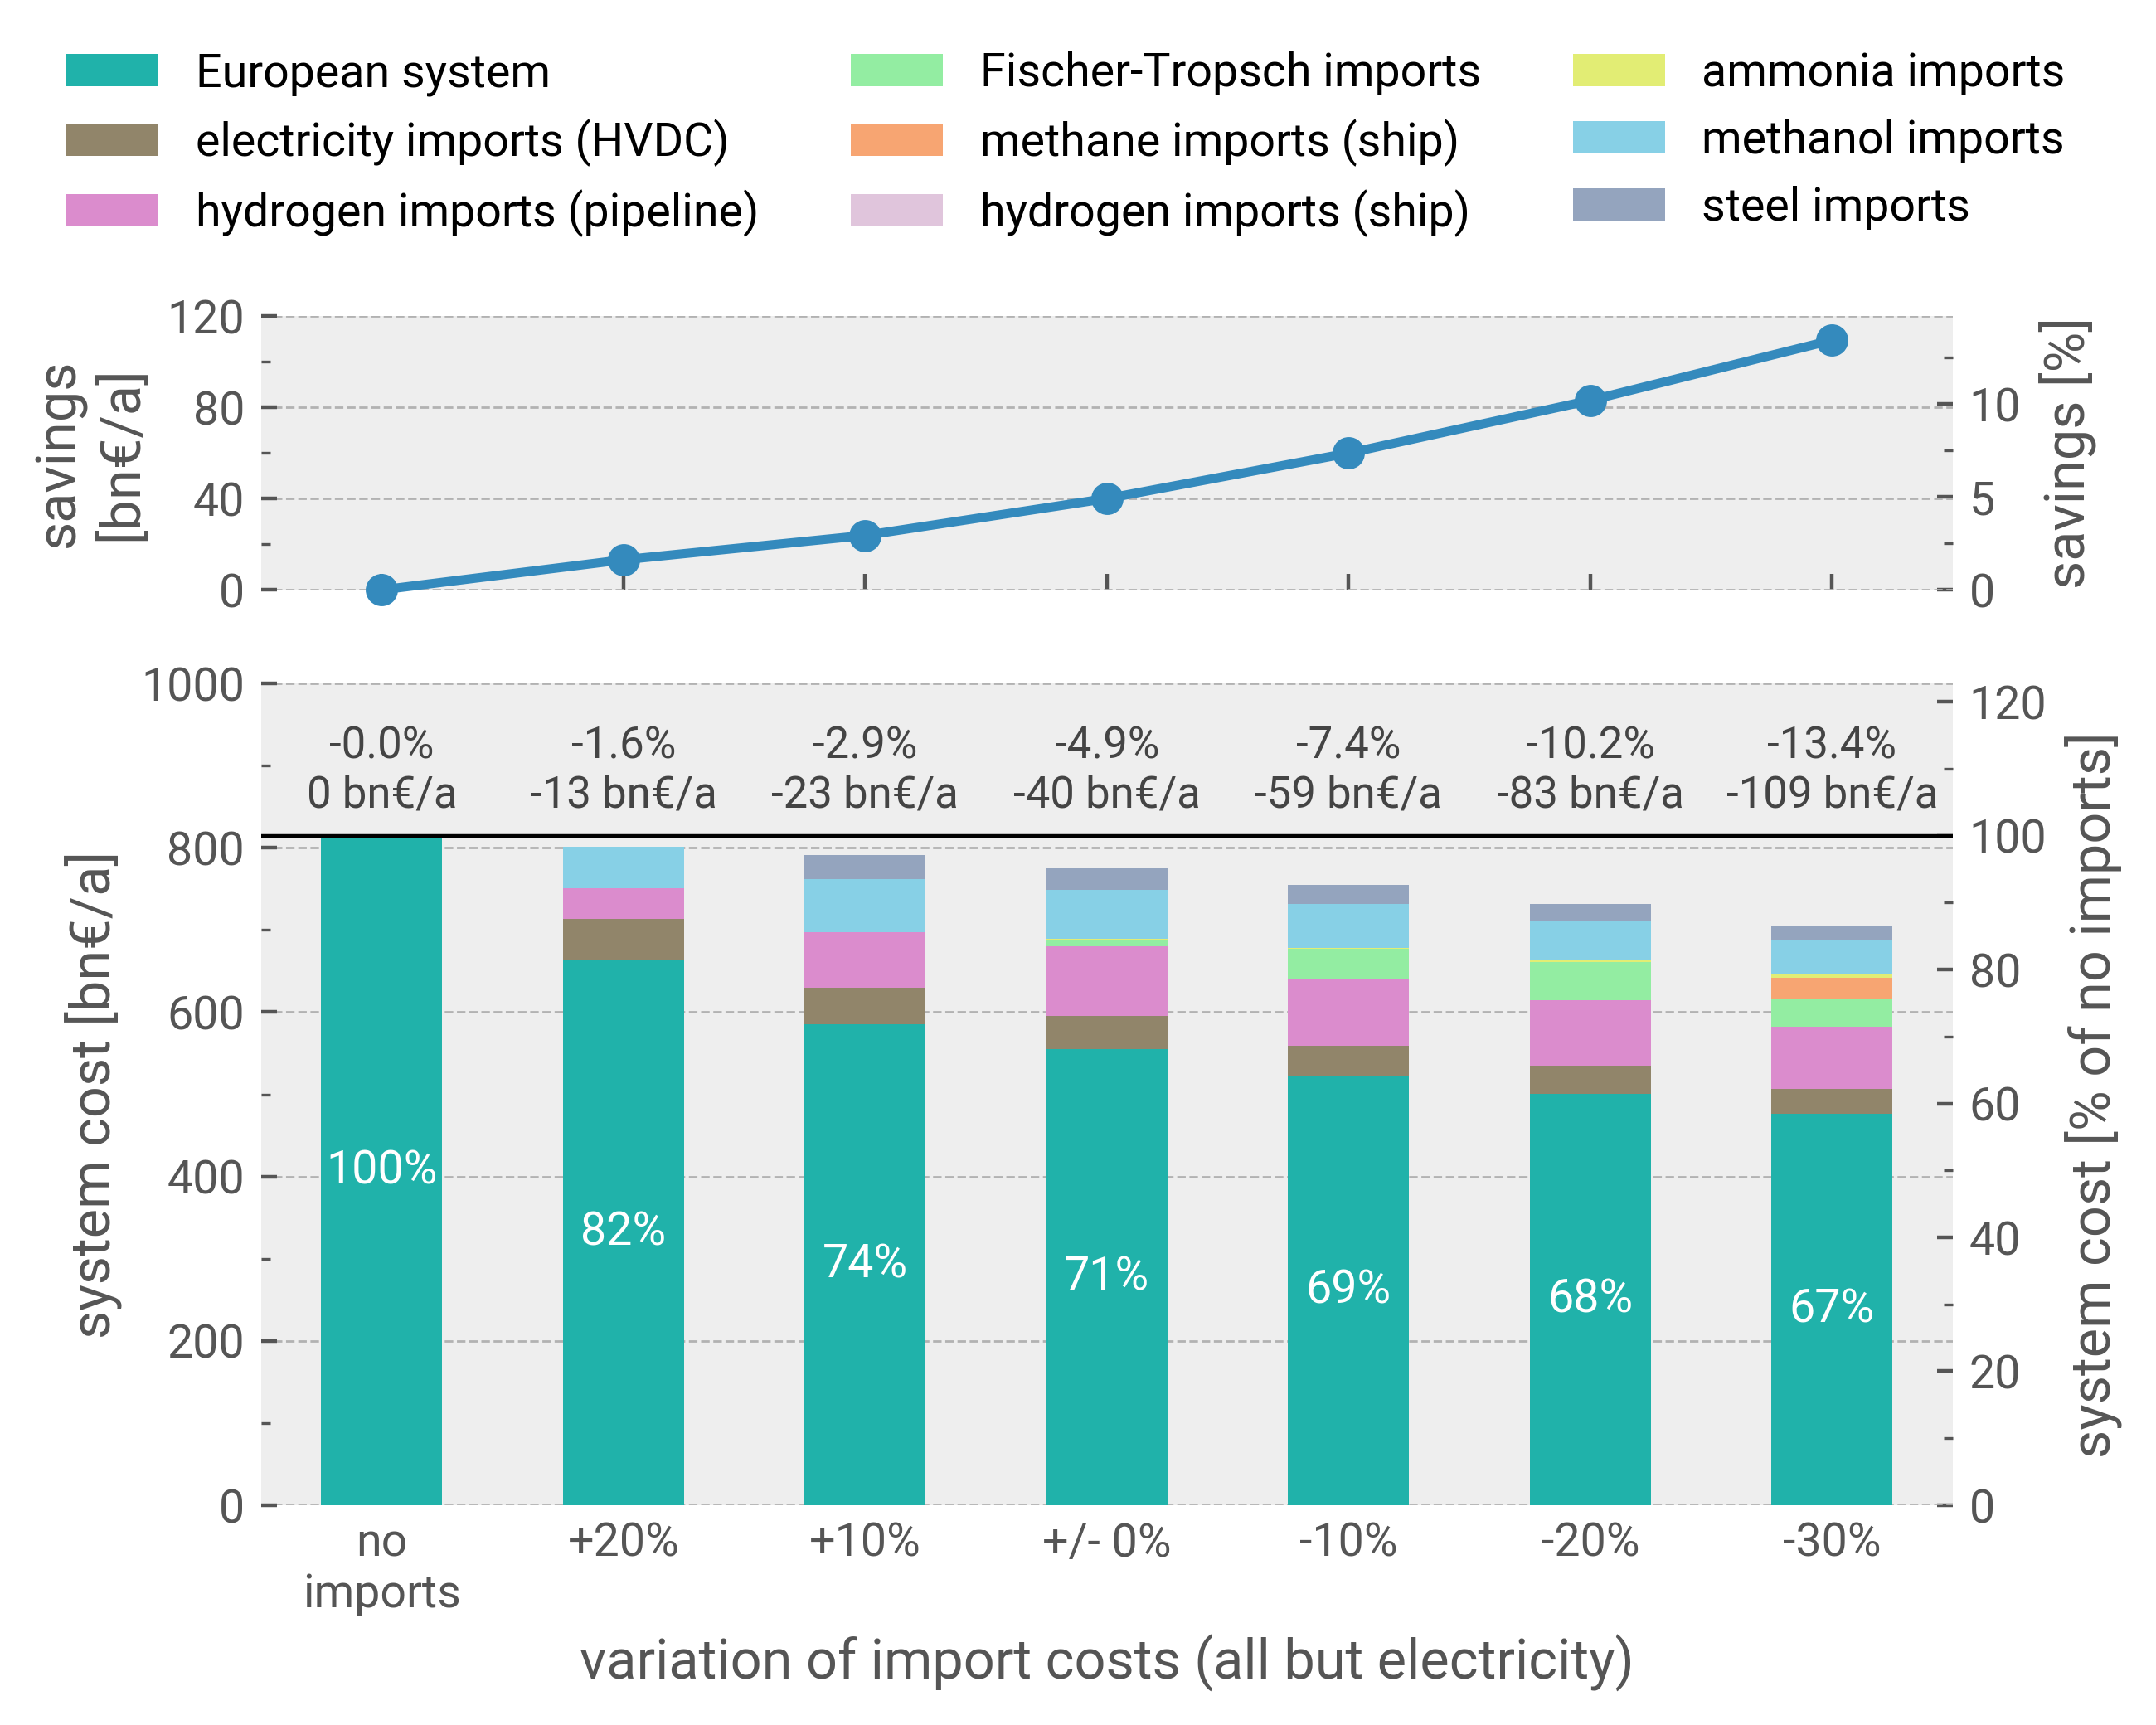

In [481]:
fig, (ax2, ax) = plt.subplots(
    2,
    1,
    figsize=(6.6, 4.5),
    gridspec_kw={"height_ratios": [1, 3]},
    sharex=True,
)

tech_colors["European system"] = "lightseagreen"
tech_colors["Import"] = "coral"

reference_cost = to_plot["no\nimports"].sum()

to_plot.T.plot.bar(ax=ax, stacked=True, color=tech_colors, legend=False)

ax.set_ylim([0, 1000])
ax.set_ylabel("system cost [bn€/a]")
ax.grid(axis="x")

ax.axhline(to_plot.sum().max(), linestyle="-", color="k", linewidth=0.8)

share = to_plot / to_plot.sum() * 100
reduction = ((-to_plot.sum() + to_plot.sum().max()) / to_plot.sum().max() * 100).round(
    1
)
abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)

for i, scen in enumerate(to_plot.columns):
    ax.text(
        i,
        850,
        f"-{reduction[scen]}%\n{abs_reduction[scen]} bn€/a",
        ha="center",
        fontsize=9.5,
        color="#444",
        # bbox=dict(
        #     facecolor="white", alpha=0.5, edgecolor="none", boxstyle="round,pad=0.3"
        # ),
    )

ax.bar_label(
    ax.containers[0],
    labels=share.loc["European system"].astype(int).astype(str) + "%",
    label_type="center",
    color="white",
    fmt="%.0f",
)

handles, labels = ax.get_legend_handles_labels()
labels = [NICE_NAMES.get(i, i) for i in labels]
fig.legend(handles, labels, ncol=3, frameon=False, bbox_to_anchor=(0.97, 1.16))

ax.tick_params(rotation=0, labelsize=10)


def abs2rel(x):
    return x / reference_cost * 100


def rel2abs(x):
    return x * reference_cost / 100


secax = ax.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax.set_ylabel("system cost [% of no imports]")

secax2 = ax2.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax2.set_ylabel("savings [%]")

for i in ["top", "right", "left", "bottom"]:
    ax.spines[i].set_visible(False)
    secax.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    secax2.spines[i].set_visible(False)

(to_plot.sum().max() - to_plot.sum()).plot(ax=ax2, marker="o", clip_on=False)
ax2.set_ylabel("savings\n[bn€/a]")
ax2.set_ylim(0, 120)
ax2.set_yticks(range(0, 121, 40))
ax2.grid(axis="x")
secax2.set_yticks([0, 5, 10, 15])
secax2.set_yticks([2.5, 7.5, 12.5], minor=True)
secax.set_yticks(range(10, 120, 20), minor=True)
ax.set_yticks(range(100, 1000, 200), minor=True)
ax2.set_yticks(range(20, 120, 40), minor=True)

ax.set_xlabel("variation of import costs (all but electricity)")

for ext in [".pdf", ".png"]:
    fig.savefig(OUTPUT + f"sensitivity-bars{suffix}" + ext, bbox_inches="tight")

In [482]:
suffix = "-all-C"
to_plot = df.loc[:, ~df.columns.get_level_values(0).isin(np.arange(500, 10001, 500))]

to_plot.columns = ["self-sufficient" if c[0] == 0.0 and c[1] == 'none' else c[1] for c in to_plot.columns]

to_plot = to_plot.groupby(
    lambda x: x if "import" in x or "external" in x else "European system"
).sum()

translate = {
    "self-sufficient": "no\nimports",
    "AC+H2+CH41.2+NH3+FT1.2+MeOH1.2+St": "+20%",
    "AC+H2+CH41.1+NH3+FT1.1+MeOH1.1+St": "+10%",
    "any": "default",
    "AC+H2+CH40.9+NH3+FT0.9+MeOH0.9+St": "-10%",
    "AC+H2+CH40.8+NH3+FT0.8+MeOH0.8+St": "-20%",
    "AC+H2+CH40.7+NH3+FT0.7+MeOH0.7+St": "-30%",
    # "AC+H20.6+CH40.6+NH30.6+FT0.6+MeOH0.6+St0.6": "any carrier\n-40% import costs",
}

to_plot = to_plot.loc[:, translate.keys()].rename(columns=translate)

to_plot = to_plot.loc[:, to_plot.sum().sort_values(ascending=False).index]

# make sure no imports is first
first = "no\nimports"
cols = [first] + [col for col in to_plot if col != first]
to_plot = to_plot[cols]

abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)

to_plot = to_plot.groupby(lambda x: "electricity imports (HVDC)" if x in ["external onwind", "external solar", "import hvdc-to-elec"] else x).sum()

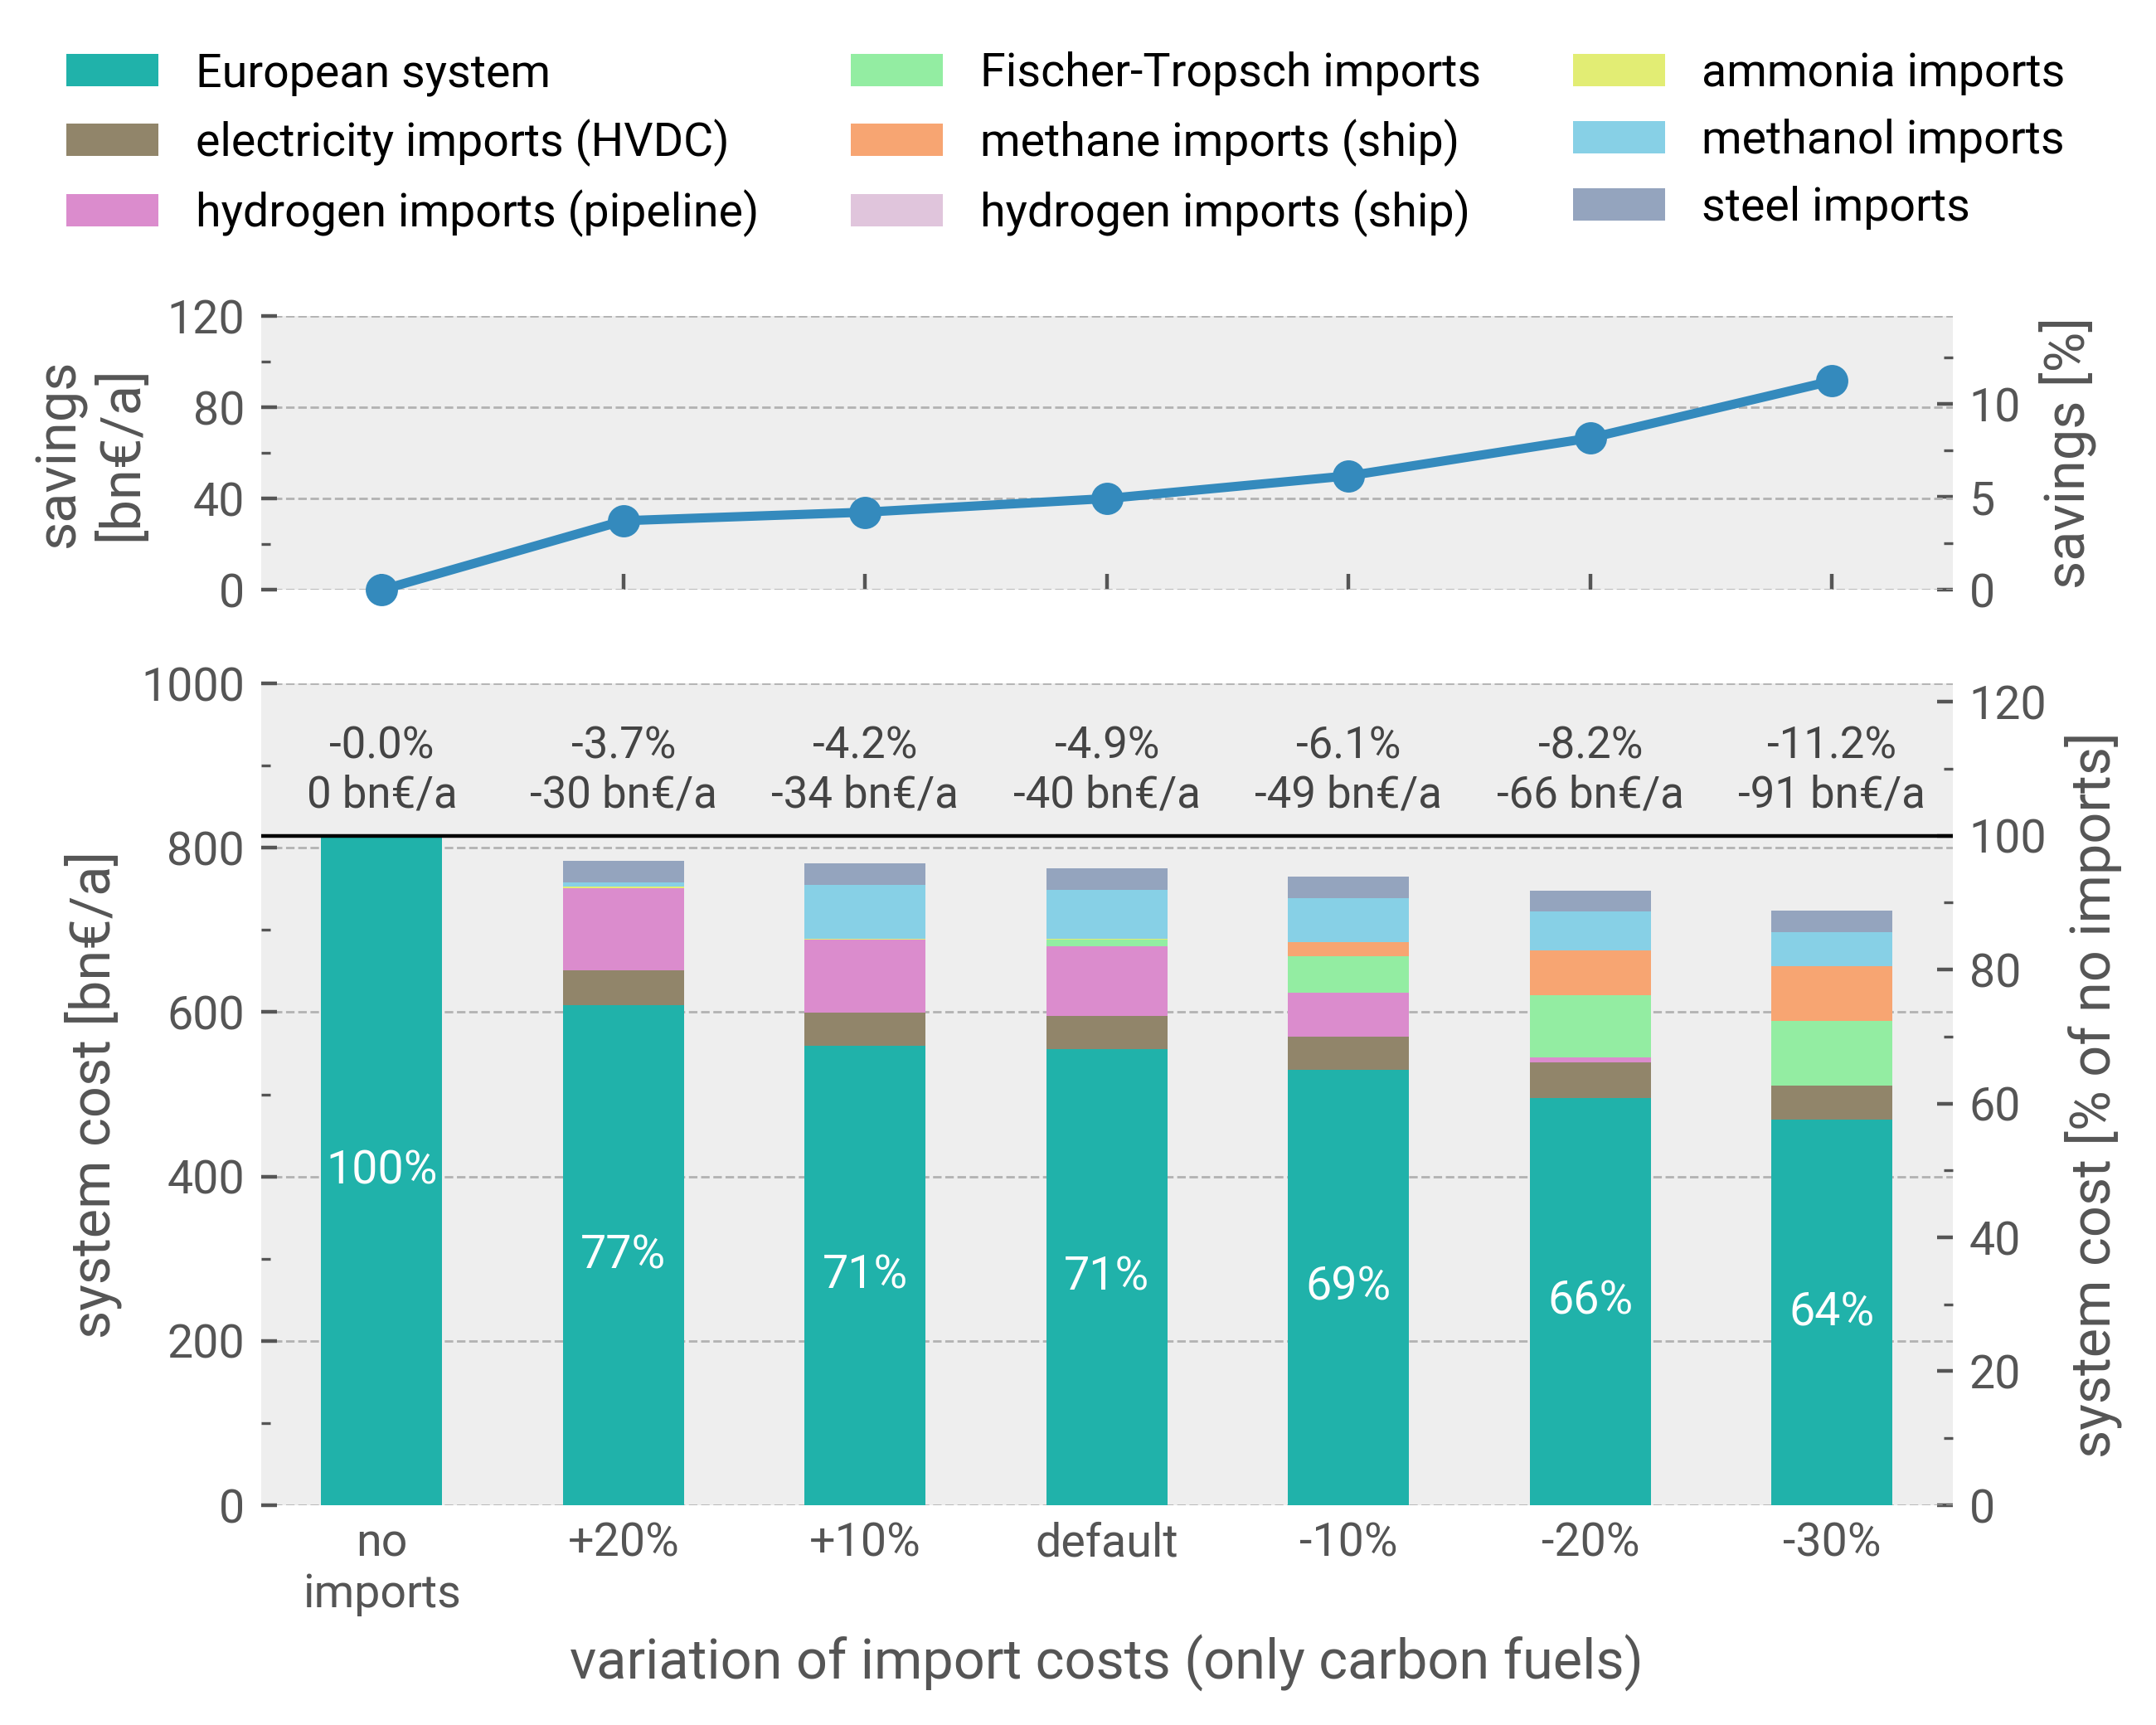

In [483]:
fig, (ax2, ax) = plt.subplots(
    2,
    1,
    figsize=(6.6, 4.5),
    gridspec_kw={"height_ratios": [1, 3]},
    sharex=True,
)

tech_colors["European system"] = "lightseagreen"
tech_colors["Import"] = "coral"

reference_cost = to_plot["no\nimports"].sum()

to_plot.T.plot.bar(ax=ax, stacked=True, color=tech_colors, legend=False)

ax.set_ylim([0, 1000])
ax.set_ylabel("system cost [bn€/a]")
ax.grid(axis="x")

ax.axhline(to_plot.sum().max(), linestyle="-", color="k", linewidth=0.8)

share = to_plot / to_plot.sum() * 100
reduction = ((-to_plot.sum() + to_plot.sum().max()) / to_plot.sum().max() * 100).round(
    1
)
abs_reduction = (to_plot.sum() - to_plot.sum().max()).astype(int)

for i, scen in enumerate(to_plot.columns):
    ax.text(
        i,
        850,
        f"-{reduction[scen]}%\n{abs_reduction[scen]} bn€/a",
        ha="center",
        fontsize=9.5,
        color="#444",
        # bbox=dict(
        #     facecolor="white", alpha=0.5, edgecolor="none", boxstyle="round,pad=0.3"
        # ),
    )

ax.bar_label(
    ax.containers[0],
    labels=share.loc["European system"].astype(int).astype(str) + "%",
    label_type="center",
    color="white",
    fmt="%.0f",
)

handles, labels = ax.get_legend_handles_labels()
labels = [NICE_NAMES.get(i, i) for i in labels]
fig.legend(handles, labels, ncol=3, frameon=False, bbox_to_anchor=(0.97, 1.16))

ax.tick_params(rotation=0, labelsize=10)


def abs2rel(x):
    return x / reference_cost * 100


def rel2abs(x):
    return x * reference_cost / 100


secax = ax.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax.set_ylabel("system cost [% of no imports]")

secax2 = ax2.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax2.set_ylabel("savings [%]")

for i in ["top", "right", "left", "bottom"]:
    ax.spines[i].set_visible(False)
    secax.spines[i].set_visible(False)
    ax2.spines[i].set_visible(False)
    secax2.spines[i].set_visible(False)

(to_plot.sum().max() - to_plot.sum()).plot(ax=ax2, marker="o", clip_on=False)
ax2.set_ylabel("savings\n[bn€/a]")
ax2.set_ylim(0, 120)
ax2.set_yticks(range(0, 121, 40))
ax2.grid(axis="x")
secax2.set_yticks([0, 5, 10, 15])
secax2.set_yticks([2.5, 7.5, 12.5], minor=True)
secax.set_yticks(range(10, 120, 20), minor=True)
ax.set_yticks(range(100, 1000, 200), minor=True)
ax2.set_yticks(range(20, 120, 40), minor=True)

ax.set_xlabel("variation of import costs (only carbon fuels)")

for ext in [".pdf", ".png"]:
    fig.savefig(OUTPUT + f"sensitivity-bars{suffix}" + ext, bbox_inches="tight")

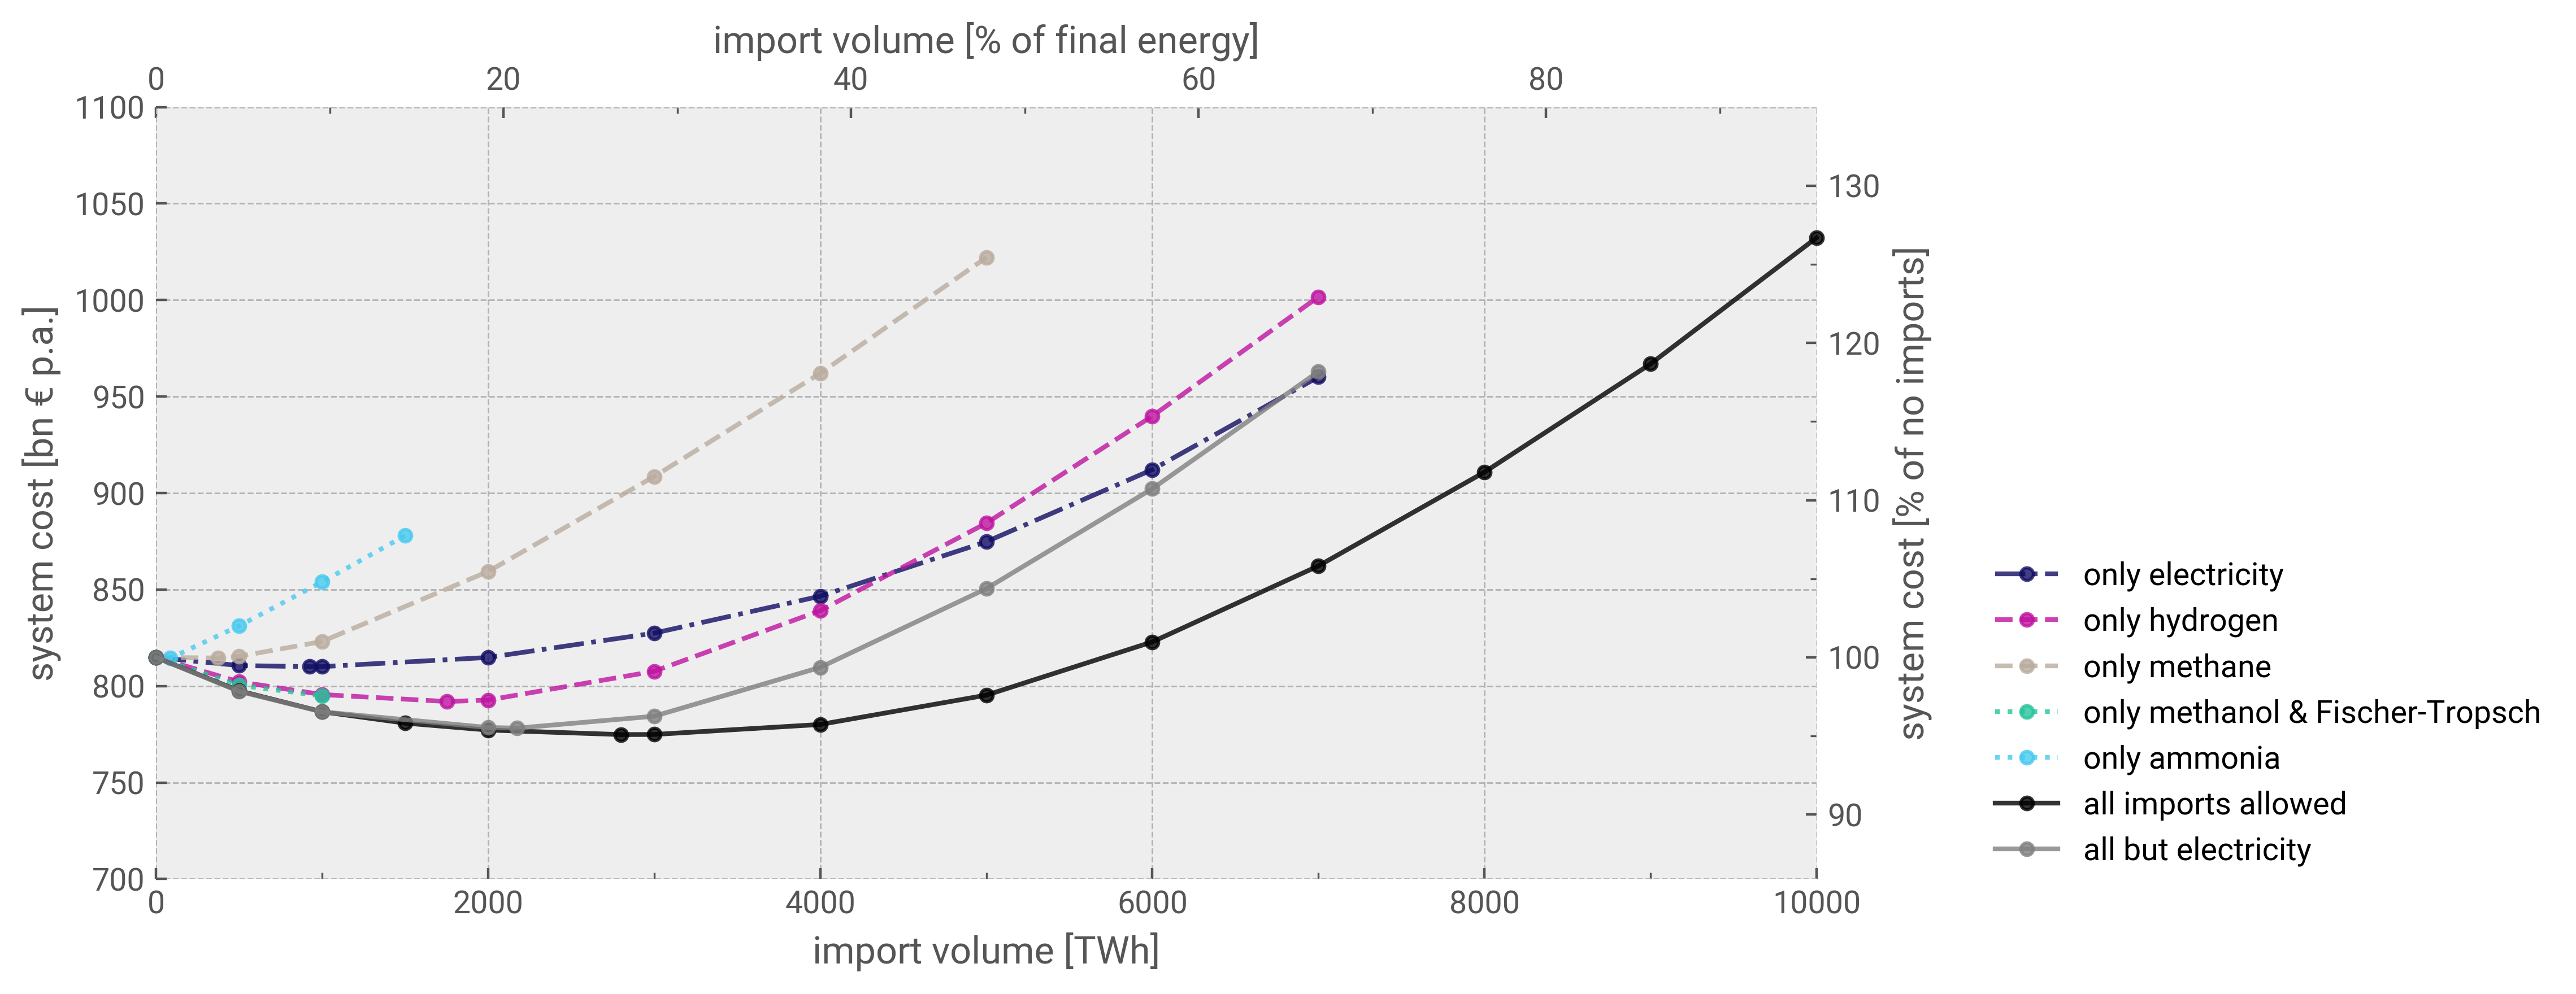

In [498]:
fig, ax = plt.subplots(1, 1, figsize=(11.5, 4.5))

kwargs = dict(marker="o", markersize=4, linewidth=1.5, alpha=0.8, clip_on=False)

no_import = df.xs("none", level="carrier", axis=1).sum()[0]

to_plot = df.xs("AC", level="carrier", axis=1).sum()
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(
    **kwargs, color=tech_colors["electricity"], label="only electricity", linestyle="-."
)

to_plot = df.xs("H2", level="carrier", axis=1).sum()
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(
    **kwargs, color=tech_colors["H2"], label="only hydrogen", linestyle="--"
)

to_plot = df.xs("CH4", level="carrier", axis=1).sum()
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(
    **kwargs, color=tech_colors["gas"], label="only methane", linestyle="--"
)

to_plot = df.xs("FT+MeOH", level="carrier", axis=1).sum()#.drop(3000)
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(
    **kwargs,
    color=tech_colors["Fischer-Tropsch"],
    label="only methanol & Fischer-Tropsch",
    linestyle=":"
)

to_plot = df.xs("NH3", level="carrier", axis=1).sum()
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(
    **kwargs, color=tech_colors["ammonia"], label="only ammonia", linestyle=":"
)

to_plot = df.xs("any", level="carrier", axis=1).sum()
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(**kwargs, color="k", label="all imports allowed", linestyle="-")

to_plot = df.xs("H2+CH4+NH3+FT+MeOH+St", level="carrier", axis=1).sum()
to_plot.loc[0.0] = no_import
to_plot.sort_index().plot(**kwargs, color="grey", label="all but electricity", linestyle="-")


ax.set_ylim(700, 1100)
ax.set_ylabel("system cost [bn € p.a.]")
ax.grid(True)

plt.xlim(0, 10000)
ax.set_xlabel("import volume [TWh]")


def abs2rel(x):
    return x / 10463 * 100


def rel2abs(x):
    return x * 10463 / 100


secax = ax.secondary_xaxis("top", functions=(abs2rel, rel2abs))
secax.set_xlabel("import volume [% of final energy]")


def abs2rel(x):
    return x / to_plot[0] * 100


def rel2abs(x):
    return x * to_plot[0] / 100


secax2 = ax.secondary_yaxis("right", functions=(abs2rel, rel2abs))
secax2.set_ylabel("system cost [% of no imports]")

for i in ["top", "right", "left", "bottom"]:
    ax.spines[i].set_visible(False)
    secax.spines[i].set_visible(False)
    secax2.spines[i].set_visible(False)

ax.set_yticks(range(700, 1100, 50), minor=True)
ax.set_xticks(range(1000, 10000, 2000), minor=True)
secax.set_xticks(range(10, 100, 20), minor=True)
secax2.set_yticks(range(95, 130, 10), minor=True)

ax.legend(ncol=1, frameon=False, loc=(1.1, 0.0))

fig.savefig(OUTPUT + "sensitivity-lines.pdf", bbox_inches="tight")